# Ollama Test 
## Categorize Expense Data

https://github.com/thu-vu92/local-llms-analyse-finance/blob/main/categorize_expenses.ipynb

### Test the LLM

In [2]:
#!pip3 install langchain_community

  Using cached PyYAML-6.0.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached SQLAlchemy-2.0.27-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.6 kB)
  Using cached aiohttp-3.9.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (7.4 kB)
  Using cached dataclasses_json-0.6.4-py3-none-any.whl.metadata (25 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl.metadata (1.0 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached frozenlist-1.4.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (31 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
  Using cached charset_no

In [3]:
from langchain_community.llms import Ollama

In [4]:
llm = Ollama(model="openchat:7b")
llm.invoke("what country is the krabi province in?")

' The Krabi Province is in Thailand.'

### Import Data

In [6]:
# Read the transactions_2022_2023.csv file 
import pandas as pd
df = pd.read_csv("transactions_2022_2023.csv")
df.head()

,Date,Name / Description,Expense/Income,Amount (EUR)
0,2023-12-30,Belastingdienst,Expense,9.96
1,2023-12-30,Tesco Breda,Expense,17.53
2,2023-12-30,Monthly Appartment Rent,Expense,451.00
3,2023-12-30,Vishandel Sier Amsterdam,Expense,12.46
4,2023-12-29,Selling Paintings,Income,13.63


In [7]:
# Get unique transactions in the Name / Description column
unique_transactions = df["Name / Description"].unique()
len(unique_transactions)

23

In [8]:
unique_transactions[1:10]

array(['Tesco Breda', 'Monthly Appartment Rent',
       'Vishandel Sier Amsterdam', 'Selling Paintings',
       'Spotify Ab By Adyen', 'Tk Maxx Amsterdam Da', 'Consulting',
       'Aidsfonds', 'Tls Bv Inz Ov-Chipkaart'], dtype=object)

### Categorize Transection with LLM

In [9]:
# Get index list
#https://stackoverflow.com/questions/47518609/for-loop-range-and-interval-how-to-include-last-step
def hop(start, stop, step):
    for i in range(start, stop, step):
        yield i
    yield stop

index_list = list(hop(0, len(unique_transactions), 10))
index_list

[0, 10, 20, 23]

In [10]:
def categorize_transactions(transaction_names, llm):
    response = llm.invoke("Can you add an appropriate category to the following expenses. For example: Spotify AB by Adyen - Entertainment, Beta Boulders Ams Amsterdam Nld - Sport, etc.. Categories should be less than 4 words. " + transaction_names)
    response = response.split('\n')

    print(response)

    # Put in dataframe
    categories_df = pd.DataFrame({'Transaction vs category': response})
    categories_df[['Transaction', 'Category']] = categories_df['Transaction vs category'].str.split(' - ', expand=True)
    
    return categories_df

In [11]:
# Test out the function
categorize_transactions('ISS Catering Services De Meern, Taxi Utrecht, Etos AMSTERDAM NLD, Bistro Bar Amsterdam',
                        llm)

[' Sure, here are the categories for the expenses you provided:', '', '1. Spotify AB by Adyen - Entertainment', '2. Beta Boulders Ams Amsterdam Nld - Sport', '3. ISS Catering Services De Meern - Catering', '4. Taxi Utrecht - Transportation', '5. Etos AMSTERDAM NLD - Groceries', '6. Bistro Bar Amsterdam - Dining']


,Transaction vs category,Transaction,Category
0,"Sure, here are the categories for the expense...","Sure, here are the categories for the expense...",None
1,,,None
2,1. Spotify AB by Adyen - Entertainment,1. Spotify AB by Adyen,Entertainment
3,2. Beta Boulders Ams Amsterdam Nld - Sport,2. Beta Boulders Ams Amsterdam Nld,Sport
4,3. ISS Catering Services De Meern - Catering,3. ISS Catering Services De Meern,Catering
5,4. Taxi Utrecht - Transportation,4. Taxi Utrecht,Transportation
6,5. Etos AMSTERDAM NLD - Groceries,5. Etos AMSTERDAM NLD,Groceries
7,6. Bistro Bar Amsterdam - Dining,6. Bistro Bar Amsterdam,Dining


In [13]:
# Intialise the categories_df_all dataframe
categories_df_all = pd.DataFrame()

# Loop through the index_list
for i in range(0, len(index_list)-1):
    transaction_names = unique_transactions[index_list[i]:index_list[i+1]]
    transaction_names = ','.join(transaction_names)

    categories_df = categorize_transactions(transaction_names, llm)
    categories_df_all = pd.concat([categories_df_all, categories_df], ignore_index=True)

[' Belastingdienst - Taxes', 'Tesco Breda - Groceries', 'Monthly Apartment Rent - Housing', 'Vishandel Sier Amsterdam - Seafood', 'Selling Paintings - Art Sales', 'Spotify Ab By Adyen - Subscription', 'Tk Maxx Amsterdam Da - Shopping', 'Consulting - Services', 'Aidsfonds - Donation', 'Tls Bv Inz Ov-Chipkaart - Transport']
[' Spotify AB by Adyen - Entertainment', 'Beta Boulders Ams Amsterdam - Sport', 'Etos Amsterdam - Retail', 'Bira Boulders Ams Amsterdam - Gym', 'Salary - Income', 'Bouldermuur Bv Amsterdam - Climbing Gym', 'Birtat Restaurant Amsterdam - Dining', 'Freelancing - Work', 'Tikkie - Payment App', 'Blogging - Writing', 'Taxi Utrecht - Transport', 'Apple Services - Technology']
[' Spotify AB by Adyen - Entertainment', 'Beta Boulders Ams Amsterdam Nld - Sport', 'Amazon Lux - Shopping', 'Classpass* Monthly - Fitness', 'Audible UK AdblCo/Pymt Gbr - Books/Audio']


In [14]:
categories_df_all

,Transaction vs category,Transaction,Category
0,Belastingdienst - Taxes,Belastingdienst,Taxes
1,Tesco Breda - Groceries,Tesco Breda,Groceries
2,Monthly Apartment Rent - Housing,Monthly Apartment Rent,Housing
3,Vishandel Sier Amsterdam - Seafood,Vishandel Sier Amsterdam,Seafood
4,Selling Paintings - Art Sales,Selling Paintings,Art Sales
5,Spotify Ab By Adyen - Subscription,Spotify Ab By Adyen,Subscription
6,Tk Maxx Amsterdam Da - Shopping,Tk Maxx Amsterdam Da,Shopping
7,Consulting - Services,Consulting,Services
8,Aidsfonds - Donation,Aidsfonds,Donation
9,Tls Bv Inz Ov-Chipkaart - Transport,Tls Bv Inz Ov-Chipkaart,Transport


In [15]:
# Get unique categories in categories_df_all
unique_categories = categories_df_all["Category"].unique()
unique_categories

array(['Taxes', 'Groceries', 'Housing', 'Seafood', 'Art Sales',
       'Subscription', 'Shopping', 'Services', 'Donation', 'Transport',
       'Entertainment', 'Sport', 'Retail', 'Gym', 'Income',
       'Climbing Gym', 'Dining', 'Work', 'Payment App', 'Writing',
       'Technology', 'Fitness', 'Books/Audio'], dtype=object)

In [16]:
# Drop NA values
categories_df_all = categories_df_all.dropna()

In [17]:
categories_df_all

,Transaction vs category,Transaction,Category
0,Belastingdienst - Taxes,Belastingdienst,Taxes
1,Tesco Breda - Groceries,Tesco Breda,Groceries
2,Monthly Apartment Rent - Housing,Monthly Apartment Rent,Housing
3,Vishandel Sier Amsterdam - Seafood,Vishandel Sier Amsterdam,Seafood
4,Selling Paintings - Art Sales,Selling Paintings,Art Sales
5,Spotify Ab By Adyen - Subscription,Spotify Ab By Adyen,Subscription
6,Tk Maxx Amsterdam Da - Shopping,Tk Maxx Amsterdam Da,Shopping
7,Consulting - Services,Consulting,Services
8,Aidsfonds - Donation,Aidsfonds,Donation
9,Tls Bv Inz Ov-Chipkaart - Transport,Tls Bv Inz Ov-Chipkaart,Transport


In [18]:
# Remove the numbering eg "1. " from Transaction column
categories_df_all['Transaction'] = categories_df_all['Transaction'].str.replace(r'\d+\.\s+', '', regex=True)
categories_df_all

,Transaction vs category,Transaction,Category
0,Belastingdienst - Taxes,Belastingdienst,Taxes
1,Tesco Breda - Groceries,Tesco Breda,Groceries
2,Monthly Apartment Rent - Housing,Monthly Apartment Rent,Housing
3,Vishandel Sier Amsterdam - Seafood,Vishandel Sier Amsterdam,Seafood
4,Selling Paintings - Art Sales,Selling Paintings,Art Sales
5,Spotify Ab By Adyen - Subscription,Spotify Ab By Adyen,Subscription
6,Tk Maxx Amsterdam Da - Shopping,Tk Maxx Amsterdam Da,Shopping
7,Consulting - Services,Consulting,Services
8,Aidsfonds - Donation,Aidsfonds,Donation
9,Tls Bv Inz Ov-Chipkaart - Transport,Tls Bv Inz Ov-Chipkaart,Transport


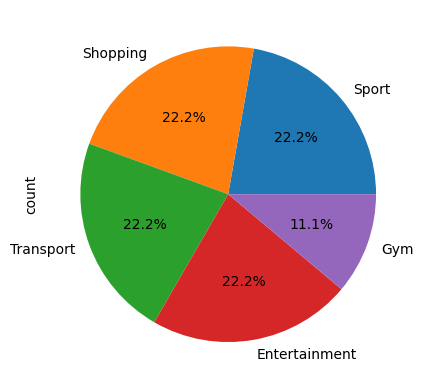

In [19]:
# Plot the top 5 categories in pie chart of the categories_df_all dataframe
categories_df_all['Category'].value_counts().head(5).plot.pie(autopct='%1.1f%%')

import matplotlib.pyplot as plt

